# [기울어진 얼굴에 고양이 수염 스티커 붙이기 - 실패]

## 0. 환경구축 및 필요한 패키지 import

In [1]:
!mkdir -p ~/aiffel/camera_sticker/models
!mkdir -p ~/aiffel/camera_sticker/images

In [2]:
!ln -s ~/data/* ~/aiffel/camera_sticker/images

ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/hero.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/image.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/camera_sticker/images/king.png': File exists


In [3]:
import os
import cv2  # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import dlib  # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


## Step 1. 스티커 구하기 or 만들기

고양이 수염 스티커는 flaticon 사이트에서 다운받았고 30도로 기울어진 얼굴사진을 인터넷에서 다운받아 png로 변환한 다음 images 폴더에 저장하고 BGR을 RGB로 변환하여 출력

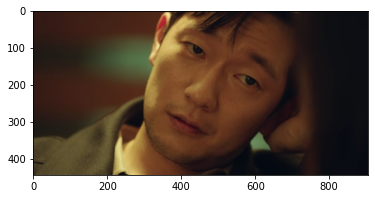

In [4]:
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/'
JKKoo_30 = cv2.imread(image_path+'JKKoo_30deg.png')
JKKoo_30_rgb = cv2.cvtColor(JKKoo_30, cv2.COLOR_BGR2RGB)
plt.imshow(JKKoo_30_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

rectangles[[(312, 63) (633, 384)]]


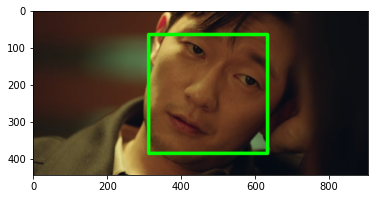

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()
JKKoo_30_rgb = cv2.cvtColor(JKKoo_30, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(JKKoo_30_rgb, 1)

img_show = JKKoo_30.copy()
print(dlib_rects)   
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 8, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
list_landmarks.clear()
for dlib_rect in dlib_rects:
    points = landmark_predictor(JKKoo_30_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
        
print(len(list_landmarks[0]))

68


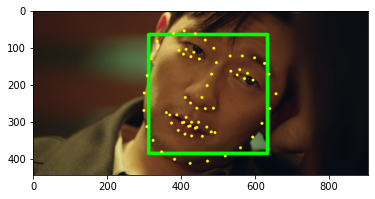

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 4, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(456, 233)
(x,y) : (456,233)
(w,h) : (322,322)


In [9]:
image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/24674.png'
img_sticker = cv2.imread(image_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(322, 322, 3)


In [10]:
refined_x = x - (w // 2)
refined_y = y - (h // 2)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (295,72)


x, y 모두 양수값이므로 스티커가 원본이미지를 벗어나지 않는다.

## Step 4. 스티커 적용하기

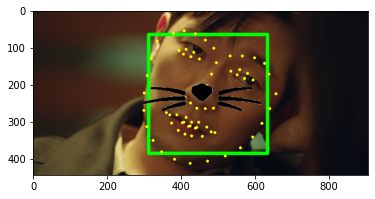

In [11]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] \
    = np.where(img_sticker == 255, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염이 코 부위에 위치하기는 하였으나 수염이 얼굴의 기울기를 반영하지 못하고 수평으로 표현되었다.

In [12]:
import math

# 이미지에서 얼굴의 회전 각도를 구하기 위하여 턱 끝(8번) 좌표와 미간(27번) 좌표를 이용함 
print (landmark[8])
print (landmark[27])

dx = landmark[8][0] - landmark[27][0]
dy = landmark[8][1] - landmark[27][1]
print('dx:', dx, ',', 'dy:', dy)

ang = math.atan(dx/dy)/math.pi*180
print("얼굴이 기울어진 각도:", -round(ang,2))  # 시계방향으로 기울었으므로 (-)부호를 붙임

(382, 400)
(495, 139)
dx: -113 , dy: 261
얼굴이 기울어진 각도: 23.41


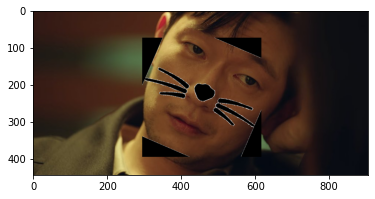

In [13]:
# 얼굴이 기울어진 각도만큼 스티커이미지의 중심을 기준으로 스티커를 회전
cp = (img_sticker.shape[0] // 2, img_sticker.shape[1] // 2)
matrix = cv2.getRotationMatrix2D(cp, ang, 1)
img_sticker = cv2.warpAffine(img_sticker, matrix, (w, h))

# 수평으로 표현된 스티커를 없애기 위해 원본 이미지를 다시 복사해 옴
img_show = JKKoo_30.copy()

sticker_origin = (landmark[30][0] - w // 2, landmark[30][1] - h // 2)
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y: sticker_origin[1] + w, refined_x: sticker_origin[0] + h] \
    = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

# bgr 이미지를 rgb 이미지로 전환하여 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 소회
고양이 수염 스티커가 기울어진 얼굴에 맞춰 잘 표현되었다.

그러나 회전시키기 전의 스티커 영역이 잘려나가 검은색으로 표현되었다.

원인분석을 위하여 img_sticker와 원래의 sticker_area를 프린트 해보기로 함. (스티커를 붙이기 전 위치에 print 코드를 추가함. ## 참조)

결과, img_sticker의 4군데가 검은색으로 바뀌어있어 스티커를 붙일때 같이 표현되었음을 알 수 있다. 이 부분을 흰색으로 바꾸어 주면 된다.
1. 원래의 스티커에서 스티커부분의 색을 검은색에서 빨강색으로 바꾼 후 진행한다.
2. 각도를 기울인 스티커에서 검은색을 흰색으로 바꾼다. (4군데 검은부분이 사라짐)
3. 빨강색을 다시 검은색으로 바꾼다.

별도로 작성한 Ex07.Camera_Sticker-Face_Angle-Final 참조